# Students Performance

Librerías especiales para correr este cuadernillo: **fancyimpute, ipywidgets.**

## Imports

In [122]:
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from fancyimpute import KNN
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.linear_model import LogisticRegression
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.cluster.vq import kmeans, vq
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

## Reading the Data

In [123]:
data_original = pd.read_csv("xAPI-Edu-Data.csv")

In [124]:
data_original.head()

,gender,NationalITy,PlaceofBirth,StageID,GradeID,SectionID,Topic,Semester,Relation,raisedhands,VisITedResources,AnnouncementsView,Discussion,ParentAnsweringSurvey,ParentschoolSatisfaction,StudentAbsenceDays,Class
0,M,KW,KuwaIT,lowerlevel,G-04,A,IT,F,Father,15,16,2,20,Yes,Good,Under-7,M
1,M,KW,KuwaIT,lowerlevel,G-04,A,IT,F,Father,20,20,3,25,Yes,Good,Under-7,M
2,M,KW,KuwaIT,lowerlevel,G-04,A,IT,F,Father,10,7,0,30,No,Bad,Above-7,L
3,M,KW,KuwaIT,lowerlevel,G-04,A,IT,F,Father,30,25,5,35,No,Bad,Above-7,L
4,M,KW,KuwaIT,lowerlevel,G-04,A,IT,F,Father,40,50,12,50,No,Bad,Above-7,M


## Generación datos faltantes

Inicialmente se separa la clase del resto del dataset para que no se vayan a generar valores faltantes dentro de la misma.

In [125]:
data_original.columns

Index(['gender', 'NationalITy', 'PlaceofBirth', 'StageID', 'GradeID',
       'SectionID', 'Topic', 'Semester', 'Relation', 'raisedhands',
       'VisITedResources', 'AnnouncementsView', 'Discussion',
       'ParentAnsweringSurvey', 'ParentschoolSatisfaction',
       'StudentAbsenceDays', 'Class'],
      dtype='object')

In [126]:
data_sc = data_original.drop(columns="Class", axis=1)
data_sc.head()

,gender,NationalITy,PlaceofBirth,StageID,GradeID,SectionID,Topic,Semester,Relation,raisedhands,VisITedResources,AnnouncementsView,Discussion,ParentAnsweringSurvey,ParentschoolSatisfaction,StudentAbsenceDays
0,M,KW,KuwaIT,lowerlevel,G-04,A,IT,F,Father,15,16,2,20,Yes,Good,Under-7
1,M,KW,KuwaIT,lowerlevel,G-04,A,IT,F,Father,20,20,3,25,Yes,Good,Under-7
2,M,KW,KuwaIT,lowerlevel,G-04,A,IT,F,Father,10,7,0,30,No,Bad,Above-7
3,M,KW,KuwaIT,lowerlevel,G-04,A,IT,F,Father,30,25,5,35,No,Bad,Above-7
4,M,KW,KuwaIT,lowerlevel,G-04,A,IT,F,Father,40,50,12,50,No,Bad,Above-7


Seguido de esto se procede a hacer la generación de valores faltantes de manera aleatoria.

El siguiente codigo fue tomado y adaptado de: https://cmdlinetips.com/2019/05/how-to-randomly-add-nan-to-pandas-dataframe/

In [127]:
data_NaN = data_sc.mask(np.random.random(data_sc.shape)<0.1)
data_NaN

,gender,NationalITy,PlaceofBirth,StageID,GradeID,SectionID,Topic,Semester,Relation,raisedhands,VisITedResources,AnnouncementsView,Discussion,ParentAnsweringSurvey,ParentschoolSatisfaction,StudentAbsenceDays
0,M,KW,KuwaIT,lowerlevel,G-04,A,IT,F,Father,15.0,16.0,2.0,20.0,NaN,Good,Under-7
1,M,KW,KuwaIT,NaN,G-04,NaN,IT,F,Father,20.0,20.0,3.0,25.0,Yes,Good,Under-7
2,M,KW,KuwaIT,lowerlevel,G-04,NaN,IT,F,Father,10.0,7.0,NaN,30.0,No,Bad,Above-7
3,M,KW,KuwaIT,lowerlevel,G-04,A,IT,F,Father,30.0,25.0,5.0,35.0,No,Bad,Above-7
4,M,KW,NaN,lowerlevel,G-04,A,IT,F,Father,NaN,50.0,12.0,50.0,No,NaN,Above-7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
475,F,Jordan,Jordan,MiddleSchool,G-08,A,Chemistry,S,Father,5.0,NaN,5.0,8.0,No,Bad,Above-7
476,F,Jordan,Jordan,MiddleSchool,G-08,A,Geology,F,Father,50.0,77.0,14.0,28.0,NaN,Bad,Under-7
477,NaN,Jordan,Jordan,MiddleSchool,G-08,A,Geology,S,Father,55.0,74.0,NaN,29.0,No,Bad,Under-7
478,F,Jordan,Jordan,MiddleSchool,G-08,A,History,F,Father,30.0,17.0,14.0,57.0,NaN,NaN,Above-7


Ahora, se le añade al dataset con valores faltantes la clase anteriormente eliminada.

In [128]:
data_NaN["Class"] = data_original["Class"]
data_NaN.head()

,gender,NationalITy,PlaceofBirth,StageID,GradeID,SectionID,Topic,Semester,Relation,raisedhands,VisITedResources,AnnouncementsView,Discussion,ParentAnsweringSurvey,ParentschoolSatisfaction,StudentAbsenceDays,Class
0,M,KW,KuwaIT,lowerlevel,G-04,A,IT,F,Father,15.0,16.0,2.0,20.0,NaN,Good,Under-7,M
1,M,KW,KuwaIT,NaN,G-04,NaN,IT,F,Father,20.0,20.0,3.0,25.0,Yes,Good,Under-7,M
2,M,KW,KuwaIT,lowerlevel,G-04,NaN,IT,F,Father,10.0,7.0,NaN,30.0,No,Bad,Above-7,L
3,M,KW,KuwaIT,lowerlevel,G-04,A,IT,F,Father,30.0,25.0,5.0,35.0,No,Bad,Above-7,L
4,M,KW,NaN,lowerlevel,G-04,A,IT,F,Father,NaN,50.0,12.0,50.0,No,NaN,Above-7,M


Seguido de esto se guarda el archivo como CSV para que no siga siendo alterado de manera aleatoria.

In [129]:
data_NaN.to_csv("studentperformancealeatorio.csv", index=False)

Se procede a cargar de nuevo el dataset estatico con valores faltantes. Este dataset es diferente al guardado anteriormente ya que es uno que se descargó antes para que dejara de variar aleatoriamente.

In [130]:
data = pd.read_csv("studentperformance.csv")
data.head()

,gender,NationalITy,PlaceofBirth,StageID,GradeID,SectionID,Topic,Semester,Relation,raisedhands,VisITedResources,AnnouncementsView,Discussion,ParentAnsweringSurvey,ParentschoolSatisfaction,StudentAbsenceDays,Class
0,M,KW,KuwaIT,lowerlevel,G-04,A,IT,F,Father,15.0,16.0,2.0,20.0,Yes,Good,Under-7,M
1,M,KW,KuwaIT,lowerlevel,G-04,A,IT,F,Father,20.0,NaN,NaN,25.0,Yes,Good,Under-7,M
2,M,KW,NaN,lowerlevel,G-04,A,NaN,F,Father,10.0,7.0,0.0,30.0,No,Bad,Above-7,L
3,NaN,KW,KuwaIT,lowerlevel,NaN,A,IT,NaN,Father,30.0,25.0,5.0,35.0,No,Bad,Above-7,L
4,M,KW,KuwaIT,lowerlevel,G-04,A,IT,NaN,Father,40.0,50.0,12.0,50.0,No,Bad,Above-7,M


Seguido de esto, se verifica que la cantidad de datos faltantes representen el 10% del data set.

In [131]:
data.isna().sum()

gender                      52
NationalITy                 52
PlaceofBirth                40
StageID                     50
GradeID                     50
SectionID                   45
Topic                       44
Semester                    64
Relation                    39
raisedhands                 43
VisITedResources            49
AnnouncementsView           49
Discussion                  52
ParentAnsweringSurvey       42
ParentschoolSatisfaction    52
StudentAbsenceDays          53
Class                        0
dtype: int64

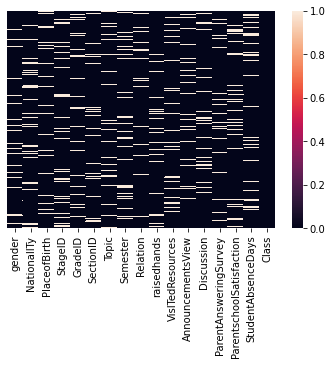

In [132]:
sns.heatmap(data.isnull(),yticklabels=False, cbar= True)

In [133]:
nan = data.isna().sum().sum()
# El dataset tiene un tamaño de 480 filas y 17 columnas contando la clase.
shape = 480 * 16
nanperc = (nan/ shape) * 100
print(f'{nanperc}%')

10.104166666666666%


In [134]:
nan

776

Los 776 datos faltantes representan un 10.10% del dataset.

## EDA

In [135]:
data.shape

(480, 17)

In [136]:
data.describe()

,raisedhands,VisITedResources,AnnouncementsView,Discussion
count,437.000000,431.000000,431.000000,428.000000
mean,46.194508,54.844548,38.232019,43.294393
std,30.829751,33.359653,26.686587,27.631436
min,0.000000,0.000000,0.000000,1.000000
25%,15.000000,17.500000,15.000000,20.000000
50%,49.000000,65.000000,33.000000,39.000000
75%,75.000000,85.000000,58.000000,70.000000
max,100.000000,99.000000,98.000000,99.000000


### Género - gender

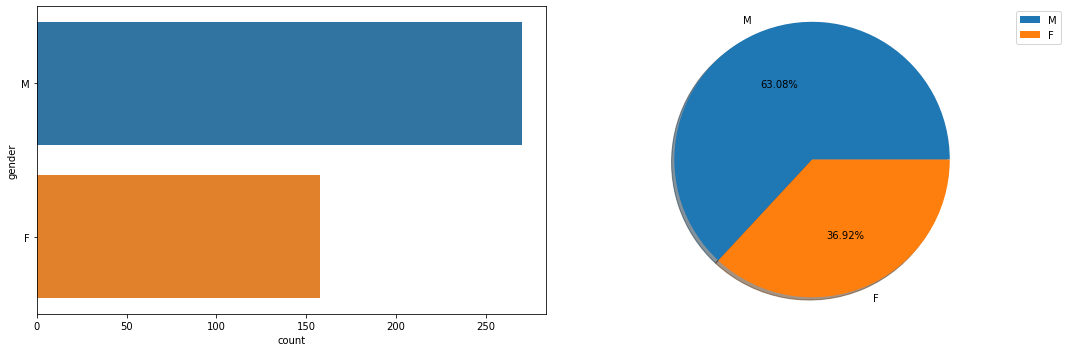

In [137]:
plt.figure(figsize = (15,5))
plt.subplot(1,2,1)
sns.countplot(y= data["gender"], palette = 'tab10', order = data['gender'].value_counts().index)

plt.subplot(1,2,2)
workclass_types = data['gender'].value_counts()
labels = list(workclass_types.index)
aggregate = list(workclass_types)
plt.pie(aggregate, labels = labels, autopct='%1.2f%%',radius = 1, shadow=True)
plt.legend(labels, loc = 'best')
plt.axis('equal')
plt.tight_layout()

plt.show()

Se puede observar que existe dominancia en la cantidad de hombres en los registros del dataset, que representan en total el 63.08% del total, frente a 36.92% que corresponden a mujeres. En este atributo se presentan 52 valores faltantes.

### Nacionalidad - NationalITy

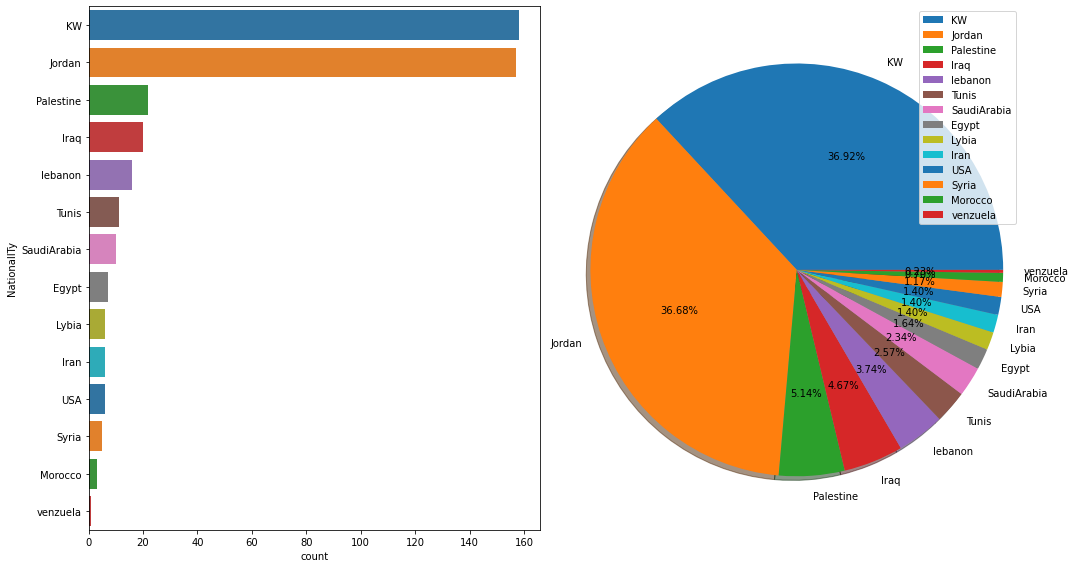

In [138]:
plt.figure(figsize = (15,8))
plt.subplot(1,2,1)
sns.countplot(y= data["NationalITy"], orient ="v", palette="tab10", order = data['NationalITy'].value_counts().index)

plt.subplot(1,2,2)
workclass_types = data['NationalITy'].value_counts()
labels = list(workclass_types.index)
aggregate = list(workclass_types)
plt.pie(aggregate, labels = labels, autopct='%1.2f%%',radius = 1, shadow=True)
plt.legend(labels, loc = 'best')
plt.axis('equal')
plt.tight_layout()

plt.show()

La nacionalidad de las personas se distribuye en 14 paises, pero predominan notoriamente las personas con nacionalidad de Kuwait y Jordania, los cuales representan un 36.92% y 36.68% respectivamente del total. En este atributo hay 52 valores faltantes. 

### Lugar de nacimiento - PlaceofBirth 

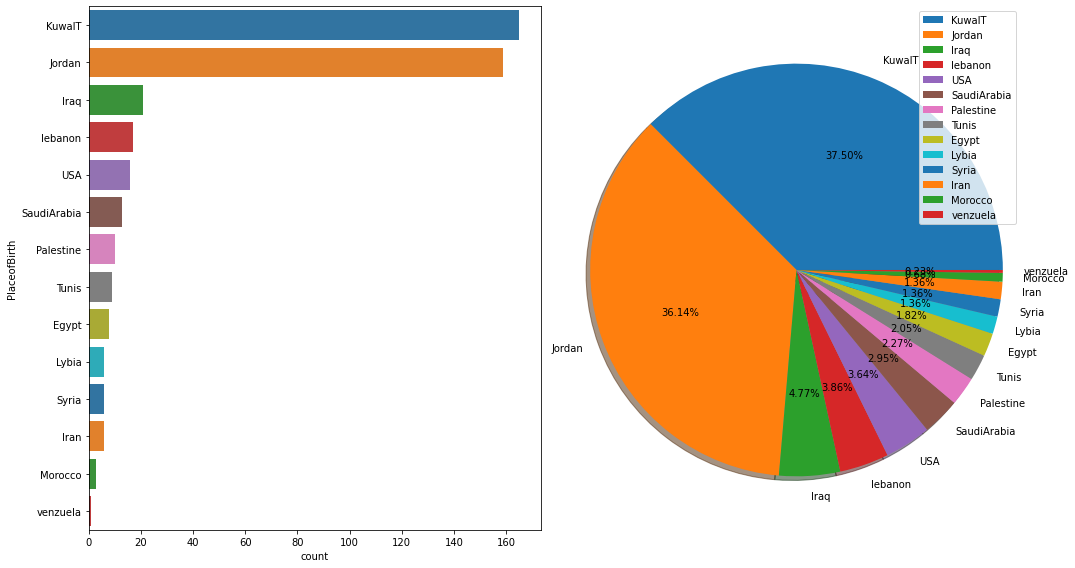

In [139]:
plt.figure(figsize = (15,8))
plt.subplot(1,2,1)
sns.countplot(y= data["PlaceofBirth"], orient ="v", palette = 'tab10', order = data['PlaceofBirth'].value_counts().index)

plt.subplot(1,2,2)
workclass_types = data['PlaceofBirth'].value_counts()
labels = list(workclass_types.index)
aggregate = list(workclass_types)
plt.pie(aggregate, labels = labels, autopct='%1.2f%%',radius = 1, shadow=True)
plt.legend(labels, loc = 'best')
plt.axis('equal')
plt.tight_layout()

plt.show()

Otro campo que se analiza es el de lugar de nacimiento, del cual se obtienen valores muy similares al atributo anterior, lo que quiere decir que en la mayoría de los casos, la nacionalidad corresponde al mismo lugar de donde nació el estudiante. En este atributo predominan Kuwait y Jordania y se presentan 40 valores faltantes. 

### Stage ID

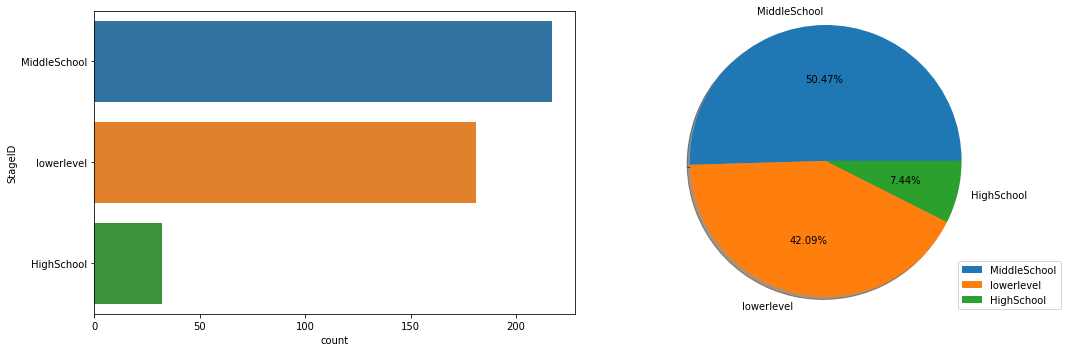

In [140]:
plt.figure(figsize = (15,5))
plt.subplot(1,2,1)
sns.countplot(y= data["StageID"], palette = 'tab10', order = data['StageID'].value_counts().index)

plt.subplot(1,2,2)
workclass_types = data['StageID'].value_counts()
labels = list(workclass_types.index)
aggregate = list(workclass_types)
plt.pie(aggregate, labels = labels, autopct='%1.2f%%',radius = 1, shadow=True)
plt.legend(labels, loc = 'best')
plt.axis('equal')
plt.tight_layout()

plt.show()

Los estudiantes registrados corresponden en un 50.47% a la categoría "Middle school", que corresponde a la etapa de enseñanza media entre primaria y bachillerato. Seguidamnete, el 42.09% corresponde a "lowerlevel" que es el nivel elemental o primaria y solo el 7.44% corresponde a "High school" o estudiantes de bachillerato. En esta variable se tienen 50 valores faltantes.

### GradeID

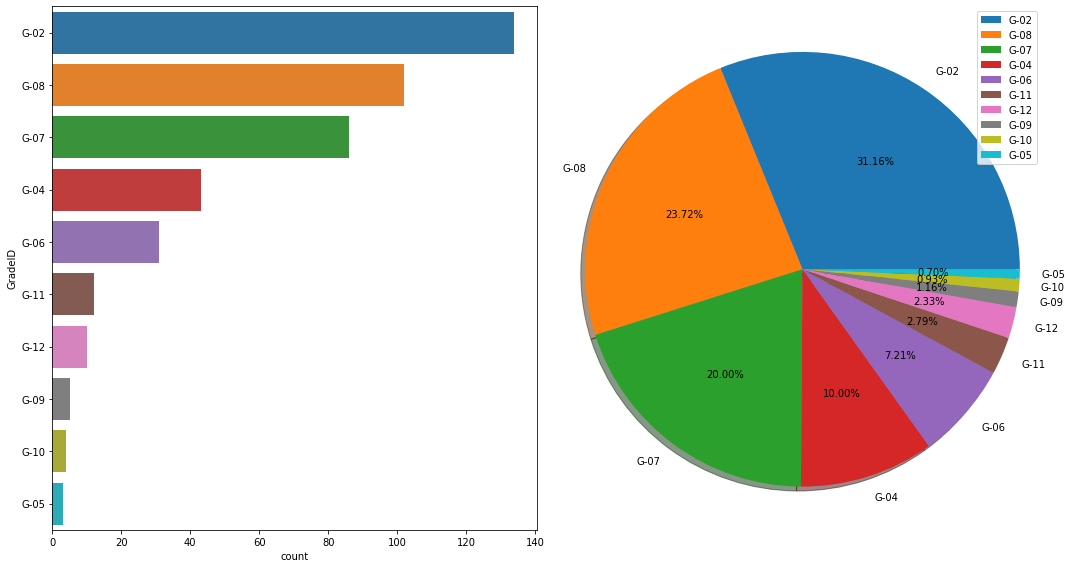

In [141]:
plt.figure(figsize = (15,8))
plt.subplot(1,2,1)
sns.countplot(y= data["GradeID"], palette = 'tab10', order = data['GradeID'].value_counts().index)

plt.subplot(1,2,2)
workclass_types = data['GradeID'].value_counts()
labels = list(workclass_types.index)
aggregate = list(workclass_types)
plt.pie(aggregate, labels = labels, autopct='%1.2f%%',radius = 1, shadow=True)
plt.legend(labels, loc = 'best')
plt.axis('equal')
plt.tight_layout()

plt.show()

En relación con el atributo de StageID, el atributo de GradeID muestra específicamente el curso en el que se encuentra cada estudiante. Se puede observar que predominan los registros de estudiantes de segundo grado (31.16%) seguido de estudiantes de octavo y séptimo grado (23.72% y 20% respectivamente). También se tienen otros registros de estudiantes de 4to, 5to, 6to, 9no, 10mo, 11 y 12 grado. Esta variable al igual que la anterior tiene 50 valores faltantes.

### SectionID

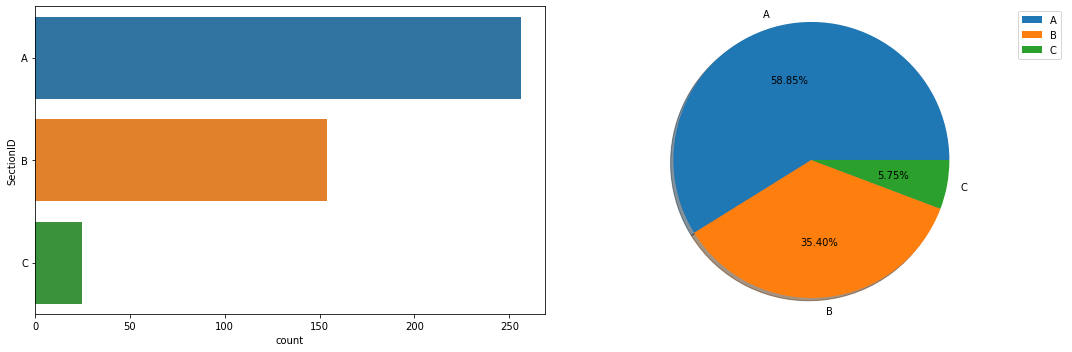

In [142]:
plt.figure(figsize = (15,5))
plt.subplot(1,2,1)
sns.countplot(y= data["SectionID"], palette = 'tab10', order = data['SectionID'].value_counts().index)

plt.subplot(1,2,2)
workclass_types = data['SectionID'].value_counts()
labels = list(workclass_types.index)
aggregate = list(workclass_types)
plt.pie(aggregate, labels = labels, autopct='%1.2f%%',radius = 1, shadow=True)
plt.legend(labels, loc = 'best')
plt.axis('equal')
plt.tight_layout()

plt.show()

Este atributo hace referencia al grupo del curso al que pertenece, (A, B o C), se observa que en los registros el 58.85% son estudiantes del grupo A, 35.40% del grupo B y 5.75% del grupo C. En este atributo hay 45 valores faltantes. 


### Tema - Topic

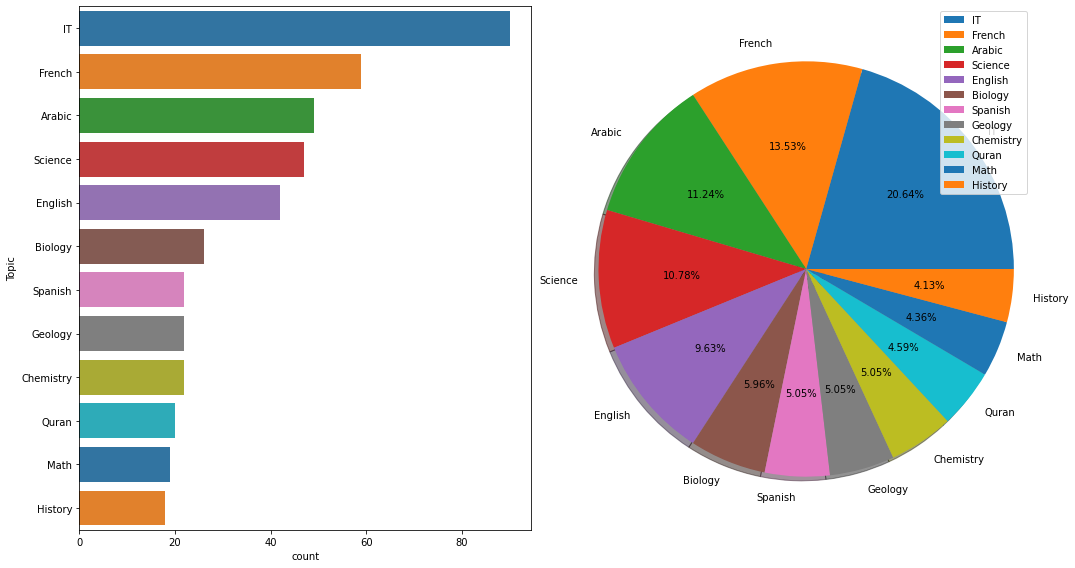

In [143]:
plt.figure(figsize = (15,8))
plt.subplot(1,2,1)
sns.countplot(y= data["Topic"], palette = 'tab10', order = data['Topic'].value_counts().index)

plt.subplot(1,2,2)
workclass_types = data['Topic'].value_counts()
labels = list(workclass_types.index)
aggregate = list(workclass_types)
plt.pie(aggregate, labels = labels, autopct='%1.2f%%',radius = 1, shadow=True)
plt.legend(labels, loc = 'best')
plt.axis('equal')
plt.tight_layout()

plt.show()

Topic hace referencia al nombre o temática de la clase a la que corresponde el registro del rendimiento del estudiante. Existen 12 cursos, donde el mayor número de registros se ven para la asignatura IT, seguido del cuso de Francés y en tercer lugar el curso de árabe. El curso de IT supera los 80 registros (20.64%). Por su parte, los cursos de español, biología, química, geología, Quran, matemáticas e historia redondean los 20 registros, es decir entre 4% y 5% del total aproximadamente. En esta categoría se tienen 44 valores faltantes.



### Semestre - Semester

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


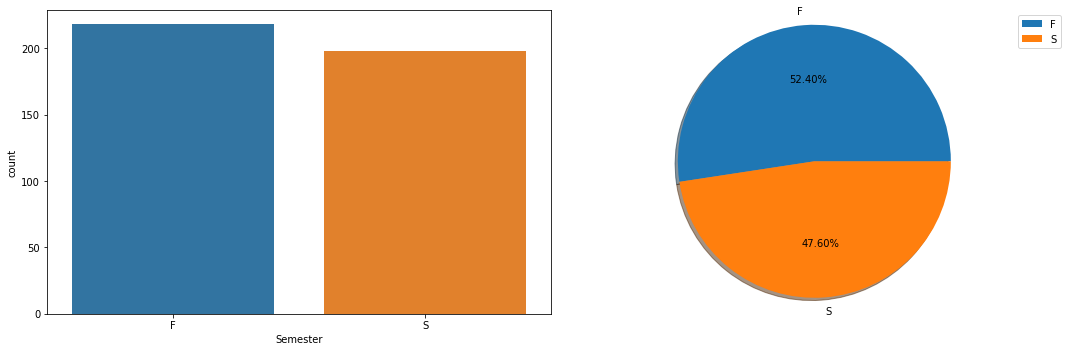

In [144]:
plt.figure(figsize = (15,5))
plt.subplot(1,2,1)
sns.countplot(data['Semester'], palette="tab10")

plt.subplot(1,2,2)
workclass_types = data['Semester'].value_counts()
labels = list(workclass_types.index)
aggregate = list(workclass_types)
plt.pie(aggregate, labels = labels, autopct='%1.2f%%',radius = 1, shadow=True)
plt.legend(labels, loc = 'best')
plt.axis('equal')
plt.tight_layout()

plt.show()

Esta variable hace referencia al semestre del año en el que se cursó la asignatura, donde F (first) se refiere al primer semestre y S (second) hace referencia al segundo. Se observar que hay un poco más de registros del primer semestre, aunque la diferencia no es significativa. Este atributo suma 64 valores faltantes.

### Relación - Relation

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


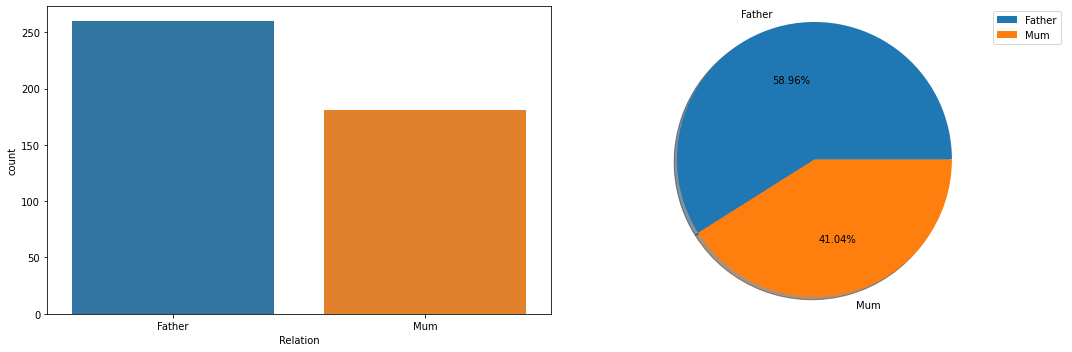

In [145]:
plt.figure(figsize = (15,5))
plt.subplot(1,2,1)
sns.countplot(data['Relation'], palette="tab10")

plt.subplot(1,2,2)
workclass_types = data['Relation'].value_counts()
labels = list(workclass_types.index)
aggregate = list(workclass_types)
plt.pie(aggregate, labels = labels, autopct='%1.2f%%',radius = 1, shadow=True)
plt.legend(labels, loc = 'best')
plt.axis('equal')
plt.tight_layout()

plt.show()

'Relation' indica el pariente que es responsable por el estudiante (acudiente). Se observa que el 58.96% de los estudiantes del dataset son responsabilidad del  padre y un 41.04% son responsabilidad de la madre. En este caso se tienen 39 valores faltantes.

### Participaciones - raisedhands

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


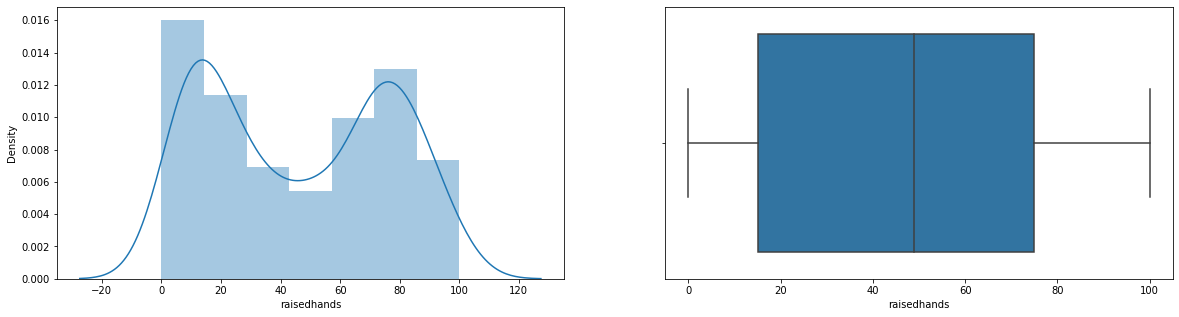

In [146]:
plt.figure(figsize = (20,5))
plt.subplot(1,2,1)
sns.distplot(data['raisedhands'])
plt.subplot(1,2,2)
sns.boxplot(x="raisedhands", data=data)
plt.show()

Este atributo hace referencia a la cantidad de veces que un estudiante alzó la mano para participar en el total de las clases. Se encuentra en un rango entre 0 y 100, con una media 46.2 veces. De igual manera se observa que los rangos más altos están entre 0 y 10 veces y entre 75 y 85 veces. En este atributo hay 43 valores faltantes.

### Fuentes visitadas - VisITedResources

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


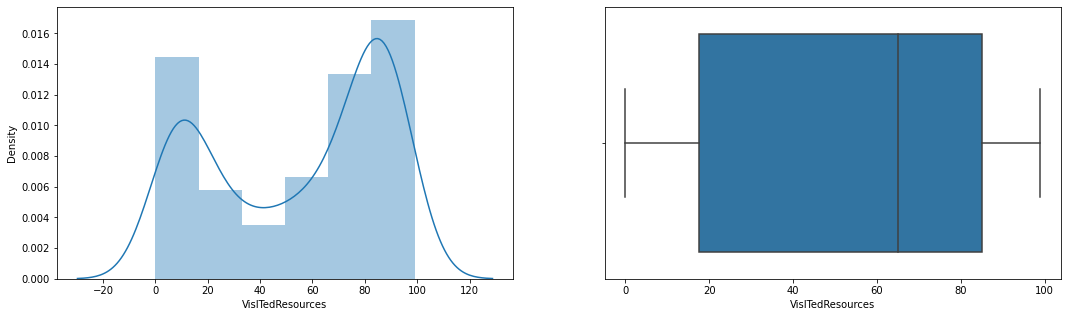

In [147]:
f, axes = plt.subplots(1, 2, figsize = (18,5))
sns.distplot(data['VisITedResources'], ax = axes[0])
sns.boxplot(x='VisITedResources', data=data, ax=axes[1])

En cuanto al atributo de fuentes visitadas, se refiere a la cantidad de veces que un alumno revisó el contenido o material del curso. Estos valores se encuentran en un rango entre 0 y 99, con una media de 54.82 veces. Los rangos que más predomiman son: 
- Entre 80 y 100 veces
-Entre 0 y 20 veces
 
 En este atributo hay 49 valores faltantes.
 


### Revisión de nuevos anuncios - AnnouncementsView


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


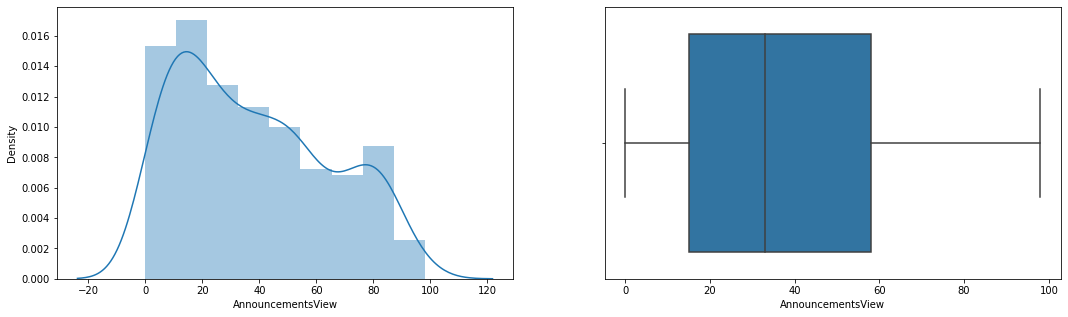

In [148]:
f, axes = plt.subplots(1, 2, figsize = (18,5))
sns.distplot(data['AnnouncementsView'], ax = axes[0])
sns.boxplot(x='AnnouncementsView', data=data, ax=axes[1])

Esta variable registra la cantidad de veces que un estudiante revisa los anuncios nuevos que se hacen. Los valores se encuentran en un rango entre 0 y 98, con una media de 38.23. La mayor densidad de registros está entre 15 y 58 veces.

 En este atributo hay 49 valores faltantes.

### Discusión - Discussion

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


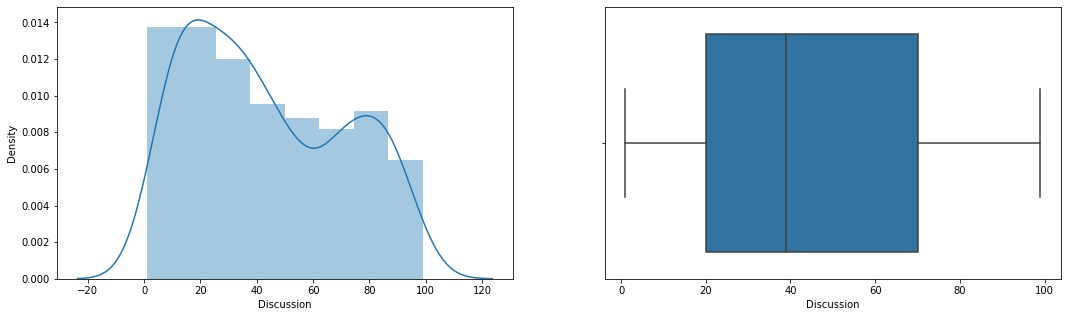

In [149]:
f, axes = plt.subplots(1, 2, figsize = (18,5))
sns.distplot(data['Discussion'], ax = axes[0])
sns.boxplot(x='Discussion', data=data, ax=axes[1])

Esta variable registra la cantidad de veces que un alumno participó en grupos de discusión durante el semestre. Estos valore están entre 1 y 99 con una media de 39. La mayor cantidad de alumnos presentan una cantidad que está entre 20 y 70 participaciones en estos grupos. 

 En este atributo hay 52 valores faltantes.

### Padres que responden la encuesta - ParentAnsweringSurvey

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


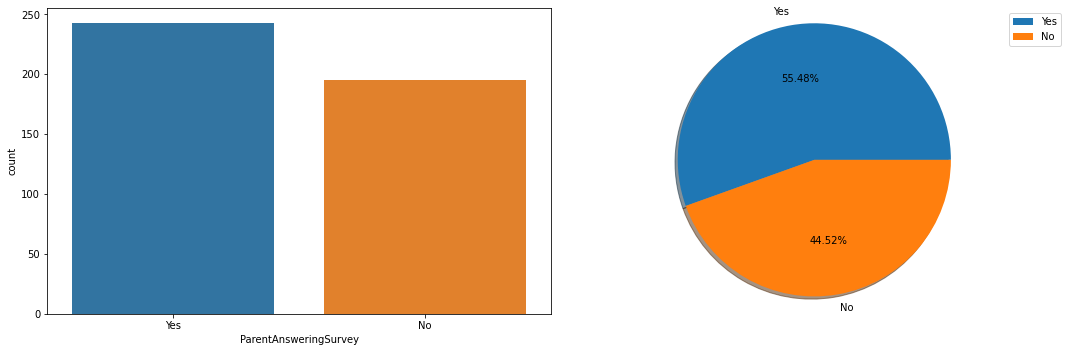

In [150]:
plt.figure(figsize = (15,5))
plt.subplot(1,2,1)
sns.countplot(data['ParentAnsweringSurvey'], palette="tab10")

plt.subplot(1,2,2)
workclass_types = data['ParentAnsweringSurvey'].value_counts()
labels = list(workclass_types.index)
aggregate = list(workclass_types)
plt.pie(aggregate, labels = labels, autopct='%1.2f%%',radius = 1, shadow=True)
plt.legend(labels, loc = 'best')
plt.axis('equal')
plt.tight_layout()

Esta variable categórica indica si los padres respondieron o no la encuesta que es suministrada por la escuela. Se puede observar que aunque la mayoría la respondieron (55.49%), existe una alta proporción que no participaron (44.52%). En esta variable se tienen 42 valores faltantes.

### Satisfacción de los padres con la escuela - ParentschoolSatisfaction

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


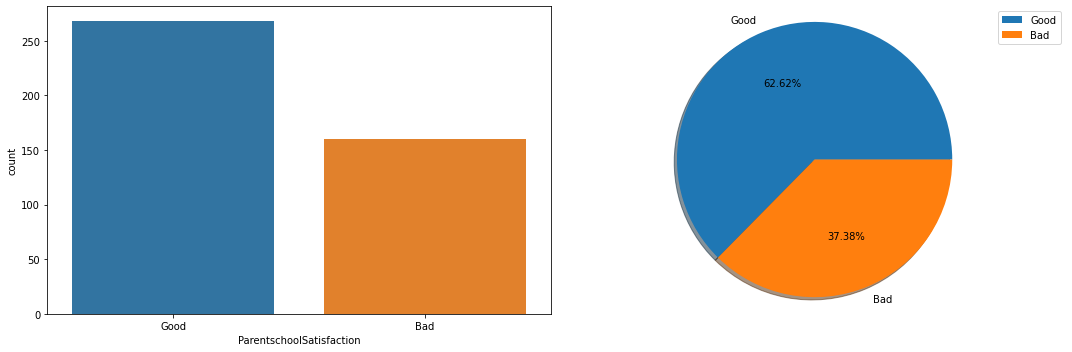

In [151]:
plt.figure(figsize = (15,5))
plt.subplot(1,2,1)
sns.countplot(data['ParentschoolSatisfaction'], palette="tab10")

plt.subplot(1,2,2)
workclass_types = data['ParentschoolSatisfaction'].value_counts()
labels = list(workclass_types.index)
aggregate = list(workclass_types)
plt.pie(aggregate, labels = labels, autopct='%1.2f%%',radius = 1, shadow=True)
plt.legend(labels, loc = 'best')
plt.axis('equal')
plt.tight_layout()

plt.show()

Esta variable muestra el grado de satisfacción de los padres con la escuela. Se puede observar que el 67.62% de los padres está satisfecho, frente al 37.38% que dice no estarlo. En esta variable hay 52 valores faltantes.

### Días de ausencia estudiantil - StudentAbsenceDays

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


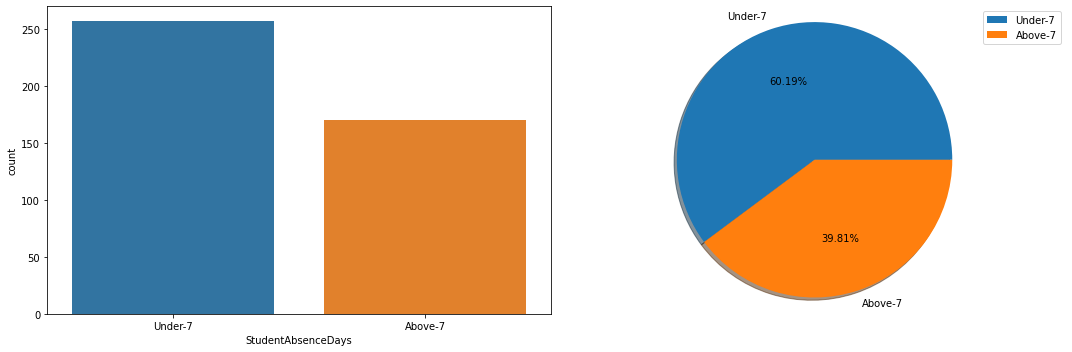

In [152]:
plt.figure(figsize = (15,5))
plt.subplot(1,2,1)
sns.countplot(data['StudentAbsenceDays'], palette="tab10")

plt.subplot(1,2,2)
workclass_types = data['StudentAbsenceDays'].value_counts()
labels = list(workclass_types.index)
aggregate = list(workclass_types)
plt.pie(aggregate, labels = labels, autopct='%1.2f%%',radius = 1, shadow=True)
plt.legend(labels, loc = 'best')
plt.axis('equal')
plt.tight_layout()

plt.show()

Esta variable muestra sin un estudiante estuvo ausente durante más de 7 días o no. El 60.19% de los estudiantes indica no haber estado ausente por más de 7 dias y el 39.81% indica haber estado ausente por más de 7 días. 

En esta variable hay 53 valores faltantes.

### Class  (Rendimento del estudiante)

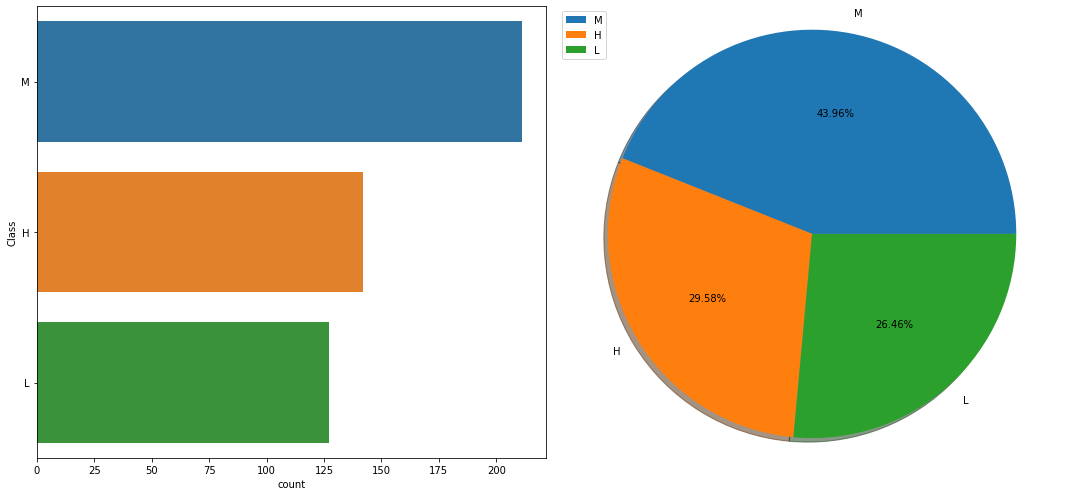

In [153]:
plt.figure(figsize = (15,7))
plt.subplot(1,2,1)
sns.countplot(y= data["Class"], palette = 'tab10', order = data['Class'].value_counts().index)


plt.subplot(1,2,2)
workclass_types = data['Class'].value_counts()
labels = list(workclass_types.index)
aggregate = list(workclass_types)
plt.pie(aggregate, labels = labels, autopct='%1.2f%%',radius = 1, shadow=True)
plt.legend(labels, loc = 'best')
plt.axis('equal')
plt.tight_layout()

plt.show()

Finalmente se analiza la clase, que corresponde al rendimiento del estudiante en la asignatura, donde L(low) es rendimiento bajo, (M) Medium es rendimiento promedio y H (High) es rendimiento alto. Se puede observar que el 43.96% tiene un rendimiento promedio, el 29.58% un rendimiento alto y el 26.46% un rendimiento bajo. La clase no presenta valores faltantes.

## Preprocesamiento

Como paso inicial se reducirá dimensionalidad teniendo en cuenta el análisis realizado anteriormente. 

Como se pudo evidenciar, las variables Nacionalidad y Pais de nacimiento no tienen diferencias significantes, por lo que se procede a trabajar con solo una de estas, eliminando "Pais de nacimiento".


In [154]:
del(data["PlaceofBirth"])
del(data_original["PlaceofBirth"])

Seguido de esto, se realiza la imputación de valores faltantes. Para esto se hará uso de dos técnicas: Imputación por la moda e imputación por KNN.

### Imputación por la moda

In [155]:
data_mode= data.copy(deep= True)
mode_imputer = SimpleImputer(strategy="most_frequent")
data_mode.iloc[:,:] = mode_imputer.fit_transform(data_mode)

In [156]:
data_mode.isna().sum()

gender                      0
NationalITy                 0
StageID                     0
GradeID                     0
SectionID                   0
Topic                       0
Semester                    0
Relation                    0
raisedhands                 0
VisITedResources            0
AnnouncementsView           0
Discussion                  0
ParentAnsweringSurvey       0
ParentschoolSatisfaction    0
StudentAbsenceDays          0
Class                       0
dtype: int64

Se puede evidenciar que ya no existe ningún valor faltante después de realizar la imputación.

### Imputación por KNN 

Debido a que existen algunas variables categóricas y la técnica KNN trabaja con valores numéricos se procede a hacer la transformación de estas variables categóricas a numéricas. 

El codigo utilizado fue tomado del curso "Dealing with Missing Data in Python" ofrecido por DataCamp

https://learn.datacamp.com/courses/dealing-with-missing-data-in-python

In [157]:
ordinal_enc_dict = {}

for col_name in data:
    ordinal_enc_dict[col_name] = OrdinalEncoder()
    col = data[col_name]
    
    col_not_null = col[col.notnull()]
    reshaped_vals = col_not_null.values.reshape(-1,1)
    encoded_vals = ordinal_enc_dict[col_name].fit_transform(reshaped_vals)
    
    data.loc[col.notnull(), col_name] = np.squeeze(encoded_vals)

Para utilizar el algoritmo KNN se definen dos valores para K, los cuales son 5 y 10.

#### KNN = 5

In [158]:
data_knn5 = data.copy(deep=True)
KNN_imputer = KNN(k=5)
data_knn5.iloc[:,:] =KNN_imputer.fit_transform(data_knn5)

Imputing row 1/480 with 0 missing, elapsed time: 0.067
Imputing row 101/480 with 2 missing, elapsed time: 0.072
Imputing row 201/480 with 2 missing, elapsed time: 0.078
Imputing row 301/480 with 3 missing, elapsed time: 0.084
Imputing row 401/480 with 0 missing, elapsed time: 0.089


In [159]:
data_knn5.isna().sum()

gender                      0
NationalITy                 0
StageID                     0
GradeID                     0
SectionID                   0
Topic                       0
Semester                    0
Relation                    0
raisedhands                 0
VisITedResources            0
AnnouncementsView           0
Discussion                  0
ParentAnsweringSurvey       0
ParentschoolSatisfaction    0
StudentAbsenceDays          0
Class                       0
dtype: int64

Al verificar que no hay datos faltantes, se regresa el dataset a su forma original.

El codigo utilizado fue tomado del curso "Dealing with Missing Data in Python" ofrecido por DataCamp

https://learn.datacamp.com/courses/dealing-with-missing-data-in-python

In [160]:
for col_name in data_knn5:
  reshaped = data_knn5[col_name].values.reshape(-1,1)
  data_knn5[col_name] = ordinal_enc_dict[col_name].inverse_transform(reshaped)

In [161]:
data_knn5.head()

,gender,NationalITy,StageID,GradeID,SectionID,Topic,Semester,Relation,raisedhands,VisITedResources,AnnouncementsView,Discussion,ParentAnsweringSurvey,ParentschoolSatisfaction,StudentAbsenceDays,Class
0,M,KW,lowerlevel,G-04,A,IT,F,Father,15.0,16.0,2.0,20.0,Yes,Good,Under-7,M
1,M,KW,lowerlevel,G-04,A,IT,F,Father,20.0,21.0,11.0,25.0,Yes,Good,Under-7,M
2,M,KW,lowerlevel,G-04,A,Geology,F,Father,10.0,7.0,0.0,30.0,No,Bad,Above-7,L
3,F,KW,lowerlevel,G-04,A,IT,F,Father,30.0,25.0,5.0,35.0,No,Bad,Above-7,L
4,M,KW,lowerlevel,G-04,A,IT,F,Father,40.0,50.0,12.0,50.0,No,Bad,Above-7,M


#### KNN = 10

In [162]:
data_knn10 = data.copy(deep=True)
KNN_imputer = KNN(k=10)
data_knn10.iloc[:,:] =KNN_imputer.fit_transform(data_knn10)

Imputing row 1/480 with 0 missing, elapsed time: 0.059
Imputing row 101/480 with 2 missing, elapsed time: 0.064
Imputing row 201/480 with 2 missing, elapsed time: 0.070
Imputing row 301/480 with 3 missing, elapsed time: 0.076
Imputing row 401/480 with 0 missing, elapsed time: 0.081


In [163]:
data_knn10.isna().sum()

gender                      0
NationalITy                 0
StageID                     0
GradeID                     0
SectionID                   0
Topic                       0
Semester                    0
Relation                    0
raisedhands                 0
VisITedResources            0
AnnouncementsView           0
Discussion                  0
ParentAnsweringSurvey       0
ParentschoolSatisfaction    0
StudentAbsenceDays          0
Class                       0
dtype: int64

In [164]:
for col_name in data_knn10:
  reshaped = data_knn10[col_name].values.reshape(-1,1)
  data_knn10[col_name] = ordinal_enc_dict[col_name].inverse_transform(reshaped)

In [165]:
data_knn10.head()

,gender,NationalITy,StageID,GradeID,SectionID,Topic,Semester,Relation,raisedhands,VisITedResources,AnnouncementsView,Discussion,ParentAnsweringSurvey,ParentschoolSatisfaction,StudentAbsenceDays,Class
0,M,KW,lowerlevel,G-04,A,IT,F,Father,15.0,16.0,2.0,20.0,Yes,Good,Under-7,M
1,M,KW,lowerlevel,G-04,A,IT,F,Father,20.0,29.0,15.0,25.0,Yes,Good,Under-7,M
2,M,KW,lowerlevel,G-04,A,History,F,Father,10.0,7.0,0.0,30.0,No,Bad,Above-7,L
3,F,KW,lowerlevel,G-05,A,IT,F,Father,30.0,25.0,5.0,35.0,No,Bad,Above-7,L
4,M,KW,lowerlevel,G-04,A,IT,F,Father,40.0,50.0,12.0,50.0,No,Bad,Above-7,M


Luego de realizar los métodos de imputación se procede a analizar la exactitud de los mismos haciendo una comparación de cada dataset generado con el data set original, los resultados se muestran a continuación. 


In [166]:
comparison_mode = data_original.eq(data_mode)
mode_acurracy= (comparison_mode.sum().sum() / (480*16)) * 100
mode_acurracy

93.93229166666667

In [167]:
comparison_knn5 = data_original.eq(data_knn5)
knn5_acurracy= (comparison_knn5.sum().sum() / (480*16)) * 100
knn5_acurracy

93.33333333333333

In [168]:
comparison_knn10 = data_original.eq(data_knn10)
knn5_acurracy= (comparison_knn10.sum().sum() / (480*16)) * 100
knn5_acurracy

93.21614583333333

Resultados:

In [169]:
diccionario_accuracy = {"Dataset":["Moda", "KNN5", "KNN10"], "Exactitud": ["93.932%", "93.333%","93.216%"]}

In [170]:
accuracyImpt = pd.DataFrame(diccionario_accuracy)
accuracyImpt

,Dataset,Exactitud
0,Moda,93.932%
1,KNN5,93.333%
2,KNN10,93.216%


De acuerdo a esto, se elige el método de imputación por moda como el mejor método de imputación y se decide dar continuidad al caso utilzando este dataset imputado.

### Normalización

Debido a que existen diferencias entre las escalas y unidades de las variables, se decide normalizar el data set para que los resultados obtenidos no tengan ningun tipo de ruido.

Para normalizar todos los datos, el primer paso es tenerlos todos en tipo númerico.

In [171]:
ordinal_enc_dict = {}

for col_name in data_mode:
    ordinal_enc_dict[col_name] = OrdinalEncoder()
    col = data_mode[col_name]
    
    col_not_null = col[col.notnull()]
    reshaped_vals = col_not_null.values.reshape(-1,1)
    encoded_vals = ordinal_enc_dict[col_name].fit_transform(reshaped_vals)
    
    data_mode.loc[col.notnull(), col_name] = np.squeeze(encoded_vals)

Seguido de esto se procede a normalizar todos los datos, sin embargo, la clase no es normalizada ya que algunos algortimos de clasificación utilizados más adelante presentarían problemas si la clase es normalizada.

In [172]:
clase = data_mode[['Class']]
values = data_mode[['gender', 'NationalITy', 'StageID', 'GradeID', 'SectionID','Topic', 'Semester', 'Relation','raisedhands','VisITedResources','AnnouncementsView', 'Discussion', 'ParentAnsweringSurvey', 'ParentschoolSatisfaction', 'StudentAbsenceDays']].values
scaler = MinMaxScaler()
scaler = scaler.fit(values)
normalized = scaler.transform(values)
data_mode = pd.DataFrame(normalized, columns=['gender', 'NationalITy', 'StageID', 'GradeID', 'SectionID','Topic', 'Semester', 'Relation','raisedhands','VisITedResources','AnnouncementsView', 'Discussion', 'ParentAnsweringSurvey', 'ParentschoolSatisfaction', 'StudentAbsenceDays']
                        )
data_mode['Class'] = clase
data_mode.head()

,gender,NationalITy,StageID,GradeID,SectionID,Topic,Semester,Relation,raisedhands,VisITedResources,AnnouncementsView,Discussion,ParentAnsweringSurvey,ParentschoolSatisfaction,StudentAbsenceDays,Class
0,1.0,0.307692,1.0,0.111111,0.0,0.636364,0.0,0.0,0.184211,0.186047,0.022989,0.204545,1.0,1.0,1.0,2.0
1,1.0,0.307692,1.0,0.111111,0.0,0.636364,0.0,0.0,0.250000,0.895349,0.137931,0.261364,1.0,1.0,1.0,2.0
2,1.0,0.307692,1.0,0.111111,0.0,0.636364,0.0,0.0,0.118421,0.081395,0.000000,0.318182,0.0,0.0,0.0,1.0
3,1.0,0.307692,1.0,0.000000,0.0,0.636364,0.0,0.0,0.368421,0.267442,0.057471,0.375000,0.0,0.0,0.0,1.0
4,1.0,0.307692,1.0,0.111111,0.0,0.636364,0.0,0.0,0.447368,0.476744,0.137931,0.522727,0.0,0.0,0.0,2.0


## **Clasificación supervisada**

### Logistic regression

Inicialmente se divide el dataset para hacer el entrenamiento y evaluación del modelo.


In [173]:
feature_cols = ['gender', 'NationalITy', 'StageID', 'GradeID', 'Topic', 'Semester', 'SectionID', 
                'Relation','raisedhands','VisITedResources','AnnouncementsView', 'Discussion', 'ParentAnsweringSurvey', 'ParentschoolSatisfaction', 'StudentAbsenceDays' ]
X = data_mode[feature_cols] # Features
y = data_mode['Class'] # Target variable
X_trainLR, X_testLR, y_trainLR, y_testLR = train_test_split(X, y, test_size = 0.2, random_state=42, stratify=y)

Se crea y evalua el modelo

In [174]:
modelLR = LogisticRegression()

In [175]:
modelLR.fit(X_trainLR, y_trainLR)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [176]:
y_predLR = modelLR.predict(X_testLR)

La evaluación del modelo se presenta más adelante.

### K-nearest neighbor (KNN)


Igualmente se divide el dataset para hacer el entrenamiento y evaluación del modelo.




In [177]:
feature_cols = ['gender', 'NationalITy', 'StageID', 'GradeID', 'Topic', 'Semester', 'SectionID',
                'Relation','raisedhands','VisITedResources','AnnouncementsView', 'Discussion', 'ParentAnsweringSurvey', 'ParentschoolSatisfaction', 'StudentAbsenceDays' ]
X = data_mode[feature_cols] # Features
y = data_mode['Class'] # Target variable
X_trainKNN, X_testKNN, y_trainKNN, y_testKNN = train_test_split(X, y, test_size = 0.2, random_state=42, stratify=y)

De manera gráfica se identifica el número de vecinos (K) que maximiza la exactitud de la clasificación, este mismo método se aplica para las 3 formas de cálculo de distancia: Euclidiana, Manhattan y chebyshev. 

El siguiente código fue tomado y adaptado del curso Supervised Learning with scikit-learn de DataCamp: https://learn.datacamp.com/courses/supervised-learning-with-scikit-learn

In [178]:
def f(Distance):
    # Setup arrays to store train and test accuracies
    neighbors = np.arange(1, 50)
    train_accuracy = np.empty(len(neighbors))
    test_accuracy = np.empty(len(neighbors))
    # Loop over different values of k
    for i, k in enumerate(neighbors):
        # Setup a k-NN Classifier with k neighbors: knn
        knn = KNeighborsClassifier(n_neighbors=k,metric = Distance)

        # Fit the classifier to the training data
        knn.fit(X_trainKNN, y_trainKNN)
        
        #Compute accuracy on the training set
        train_accuracy[i] = knn.score(X_trainKNN, y_trainKNN)

        #Compute accuracy on the testing set
        test_accuracy[i] = knn.score(X_testKNN, y_testKNN)



    # Generate plot
    plt.title('k-NN: Varying Number of Neighbors')
    plt.plot(neighbors, test_accuracy, label = 'Testing Accuracy')
    plt.plot(neighbors, train_accuracy, label = 'Training Accuracy')
    plt.legend()
    plt.xlabel('Number of Neighbors')
    plt.ylabel('Accuracy')
    plt.show()
    print(f'Exactitud máxima: {test_accuracy.max(axis=0)*100}%')
distances = ["euclidean", "manhattan","chebyshev" ]
interact(f, Distance=distances)


interactive(children=(Dropdown(description='Distance', options=('euclidean', 'manhattan', 'chebyshev'), value=…

<function __main__.f>

Según esto, el K indicado para cada método de cálculo de distancia es: 

*   Euclidiana:K=13
*   Manhattan: K=10
*   Chebyshev: K=3


Se entrena y evaulua el modelo con los tres respectivos valores de K para las tres tecnicas deiferentes de distancia.

In [179]:
# Split into training and test set
X_trainKNN, X_testKNN, y_trainKNN, y_testKNN = train_test_split(X, y, test_size = 0.2, random_state=42, stratify=y)

# Create a k-NN classifier with K neighbors: knn
knn_euclidean = KNeighborsClassifier(n_neighbors=13, metric = "euclidean")
knn_manhattan = KNeighborsClassifier(n_neighbors=10, metric = "manhattan")
knn_chebyshev = KNeighborsClassifier(n_neighbors=3, metric = "chebyshev")

# Fit the classifier to the training data
knn_euclidean.fit(X_trainKNN, y_trainKNN)
knn_manhattan.fit(X_trainKNN, y_trainKNN)
knn_chebyshev.fit(X_trainKNN, y_trainKNN)


Accuracy_1 = knn_euclidean.score(X_testKNN, y_testKNN)*100 
Accuracy_2= knn_manhattan.score(X_testKNN, y_testKNN)*100
Accuracy_3 = knn_chebyshev.score(X_testKNN, y_testKNN)*100

In [180]:
Dic_KNN_accuracy = {"Distancia":["Euclidean", "manhattan", "Chebyshev"], "Exactitud del modelo": [Accuracy_1, Accuracy_2,Accuracy_3]}

In [181]:
KNN_accuracy = pd.DataFrame(Dic_KNN_accuracy)
KNN_accuracy

,Distancia,Exactitud del modelo
0,Euclidean,72.916667
1,manhattan,78.125000
2,Chebyshev,68.750000


Se puede observar que con la distancia Manhattan es con la que se obtiene una mejor exactitud del modelo (78.12%)


### Artificial Neural Networks (ANN)

Acontinuación se aplica del método de clasificación MLP el cual es un clasificador de redes neuronales.

Igualmente se divide el dataset para hacer el entrenamiento y evaluación del modelo.

In [182]:
feature_cols = ['gender', 'NationalITy', 'StageID', 'GradeID', 'Topic', 'Semester', 'SectionID', 
                'Relation','raisedhands','VisITedResources','AnnouncementsView', 'Discussion', 'ParentAnsweringSurvey', 'ParentschoolSatisfaction', 'StudentAbsenceDays' ]
X = data_mode[feature_cols] # Features
y = data_mode['Class'] # Target variable
X_trainANN, X_testANN, y_trainANN, y_testANN = train_test_split(X, y, test_size = 0.2, random_state=42, stratify=y)

Se entrena y evalua el modelo

In [183]:
modelANN = MLPClassifier(random_state= 15)

In [184]:
modelANN.fit(X_trainANN, y_trainANN)

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=15, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [185]:
#Predict using ANN train model
y_predANN = modelANN.predict(X_testANN)

La evaluación del método se presenta más adelante.

## **Evaluación de los métodos**

### Logistic regression

In [186]:
print(confusion_matrix(y_testLR, y_predLR))

[[19  0 10]
 [ 0 21  4]
 [ 7  5 30]]


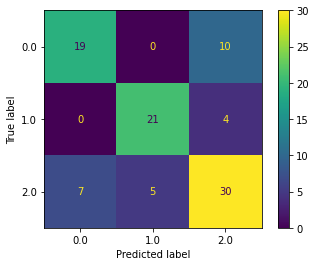

In [187]:
plot_confusion_matrix(modelLR, X_testLR, y_testLR)
plt.show()

In [188]:
Acc_LR=accuracy_score(y_testLR, y_predLR)*100
print("Accuracy:",Acc_LR)


Accuracy: 72.91666666666666


### KNN

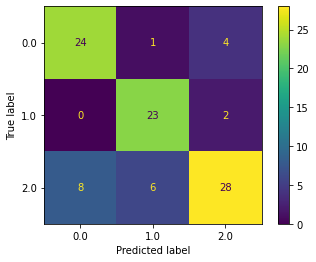

In [189]:
plot_confusion_matrix(knn_manhattan, X_testKNN, y_testKNN)
plt.show()

In [190]:
# KNN
Acc_KNN = knn_manhattan.score(X_testKNN, y_testKNN)*100
print("Accuracy:",Acc_KNN)

Accuracy: 78.125


### ANN

In [191]:
print(confusion_matrix(y_testANN, y_predANN))

[[18  0 11]
 [ 0 21  4]
 [ 9  4 29]]


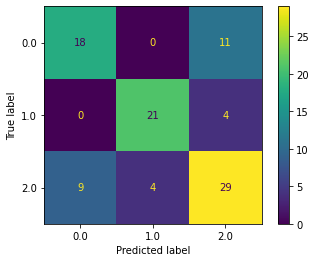

In [192]:
plot_confusion_matrix(modelANN, X_testANN, y_testANN)
plt.show()

In [193]:

Acc_ANN = accuracy_score(y_testANN, y_predANN)*100
print("Accuracy:", Acc_ANN)

Accuracy: 70.83333333333334


In [194]:
dic_accuracy_clasificacion = {"Método":["Logistic Regression", "K-Nearest Neighbour", "Artificial Neural Networks"], "Exactitud": [Acc_LR, Acc_KNN,Acc_ANN]}

### Resumen

In [195]:
accuracy_metodo = pd.DataFrame(dic_accuracy_clasificacion)
accuracy_metodo

,Método,Exactitud
0,Logistic Regression,72.916667
1,K-Nearest Neighbour,78.125000
2,Artificial Neural Networks,70.833333


Se puede evidenciar que el mejor método de clasificación es KNN

## **Clasificación no supervisada**

### K-means Clustering

Inicialmente se debe borrar la clase dentro del dataset ya que en clasificación supervisada no se conoce la clase.

In [196]:
data_cluster_kmeans = data_mode.drop("Class", axis = 1)

En las tecnicas de clustering se debe conocer cuantos grupos se quieren realizar. En el método K-means, la gráfica de codo ayuda a determinar cual es el K ideal. 

El cogido aplicado a continuación fue tomado y adaptado del curso: "Cluster Analyis in Python" ofrecido por DataCamp. https://learn.datacamp.com/courses/cluster-analysis-in-python

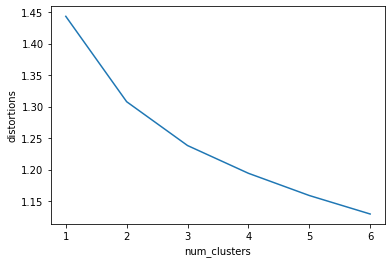

In [197]:
distortions = []
num_clusters = range(1, 7)

# Create a list of distortions from the kmeans function
for i in num_clusters:
    cluster_centers, distortion = kmeans(data_cluster_kmeans, i)
    distortions.append(distortion)

# Create a data frame with two lists - num_clusters, distortions
elbow_plot = pd.DataFrame({'num_clusters': num_clusters, 'distortions': distortions})

# Creat a line plot of num_clusters and distortions
sns.lineplot(x='num_clusters', y='distortions', data = elbow_plot)
plt.xticks(num_clusters)
plt.show()

La gráfica de codo sugiere que donde haya un punto de inflexión es el número ideal de clusters. Sin embargo, en esta no se observa ningún punto de inflexión por lo que se aplicará el método con 2 y 3 clusters.

#### 3 Clusters

In [198]:

# Generate cluster centers
cluster_centers, distortion = kmeans(data_cluster_kmeans, 3)

# Assign cluster labels
data_cluster_kmeans['cluster_labels_Kmeans'], distortion_list = vq(data_cluster_kmeans, cluster_centers)

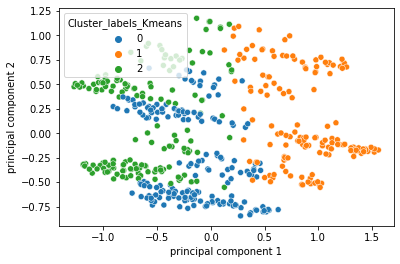

In [199]:
pca = PCA(n_components=2)
principalComponents_kmeans = pca.fit_transform(data_cluster_kmeans[feature_cols])
principalDf_kmeans = pd.DataFrame(data = principalComponents_kmeans
             , columns = ['principal component 1', 'principal component 2'])
principalDf_kmeans['Cluster_labels_Kmeans'] = data_cluster_kmeans['cluster_labels_Kmeans']
sns.scatterplot(x = 'principal component 1', y= 'principal component 2', hue = "Cluster_labels_Kmeans" ,data = principalDf_kmeans, palette='tab10')

Con 3 clusters, la diferenciación en los grupos de la izquierda no es clara, hay puntos que se sobreponen.

#### 2 Clusters

In [200]:
# Generate cluster centers
cluster_centers, distortion = kmeans(data_cluster_kmeans, 2)

# Assign cluster labels
data_cluster_kmeans['cluster_labels_Kmeans'], distortion_list = vq(data_cluster_kmeans, cluster_centers)

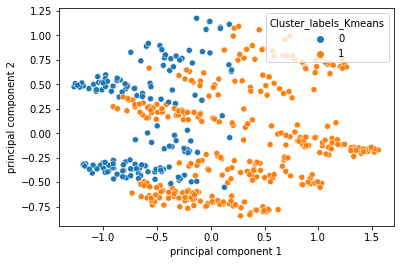

In [201]:
pca = PCA(n_components=2)
principalComponents_kmeans = pca.fit_transform(data_cluster_kmeans[feature_cols])
principalDf_kmeans = pd.DataFrame(data = principalComponents_kmeans
             , columns = ['principal component 1', 'principal component 2'])
principalDf_kmeans['Cluster_labels_Kmeans'] = data_cluster_kmeans['cluster_labels_Kmeans']
sns.scatterplot(x = 'principal component 1', y= 'principal component 2', hue = "Cluster_labels_Kmeans" ,data = principalDf_kmeans, palette='tab10')

Con dos clusters, siguen exisitiendo algunos puntos en conflicto pero la segmentación se ve mucho más diferenciada.

Ahora se hará la comparación con el metodo Hierarchical.

### Hierarchical Clustering

Se crea la función de distancia con la cual trabaja el algoritmo Hierarchical. Y se elimina la clase.

In [202]:
data_cluster_h = data_mode.drop("Class", axis = 1)

In [203]:
# Use the linkage() function to compute distance
Z = linkage(data_cluster_h, 'ward')

Con ayuda del dendogram se puede determinar cual es el número ideal de clusters en el dataset cuando se utiliza hierarchical clustering

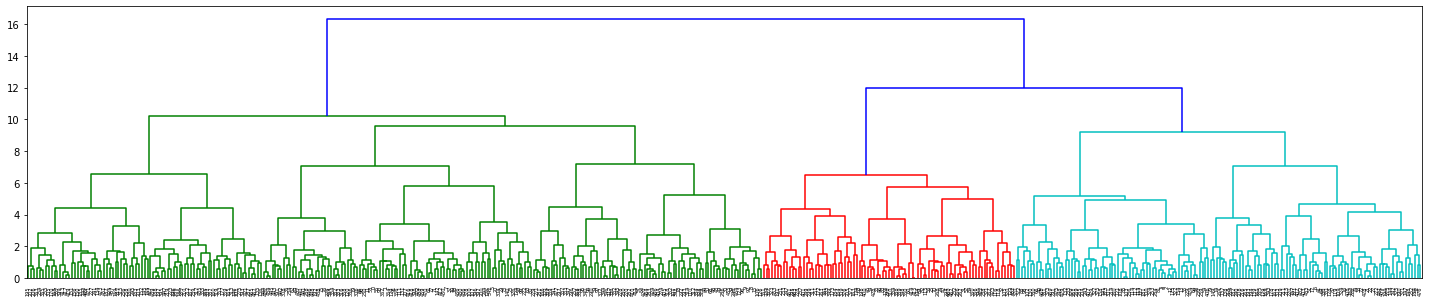

In [204]:
plt.figure(figsize = (25,5))

# Import the dendrogram function
from scipy.cluster.hierarchy import dendrogram

# Create a dendrogram
dn = dendrogram(Z)

# Display the dendogram
plt.show()

Se puede evidenciar que el número ideal de clusters es 3. Sin embargo ya se observó anteriormente que con 3 grupos la clasificación no es óptima por lo que se hará con 2 y 3 clusters igualmente.

#### 3 Clusters

In [205]:
# Generate cluster labels
data_cluster_h['cluster_labels_h'] = fcluster(Z, 3, criterion='maxclust')

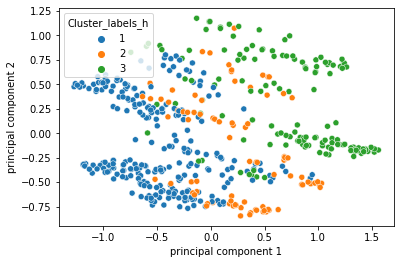

In [206]:
pca = PCA(n_components=2)
principalComponents_h = pca.fit_transform(data_cluster_h[feature_cols])
principalDf_h = pd.DataFrame(data = principalComponents_h
             , columns = ['principal component 1', 'principal component 2'])
principalDf_h['Cluster_labels_h'] = data_cluster_h['cluster_labels_h']
sns.scatterplot(x = 'principal component 1', y= 'principal component 2', hue = "Cluster_labels_h" ,data = principalDf_h, palette="tab10")

#### 2 Clusters

In [207]:
# Generate cluster labels
data_cluster_h['cluster_labels_h'] = fcluster(Z, 2, criterion='maxclust')

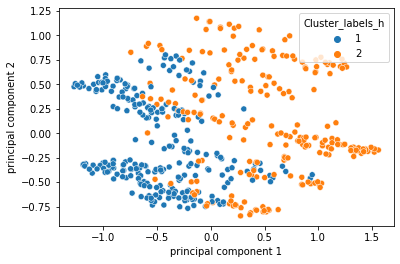

In [208]:
pca = PCA(n_components=2)
principalComponents_h = pca.fit_transform(data_cluster_h[feature_cols])
principalDf_h = pd.DataFrame(data = principalComponents_h
             , columns = ['principal component 1', 'principal component 2'])
principalDf_h['Cluster_labels_h'] = data_cluster_h['cluster_labels_h']
sns.scatterplot(x = 'principal component 1', y= 'principal component 2', hue = "Cluster_labels_h" ,data = principalDf_h, palette="tab10")

Al igual que en K Means al hacer 2 grupos la visualización de los clusters mejora, sin embargo, la distribución se ve mejor con el método K Means

En conclusión para este Data Set, el mejor metodo de clasificación  no supervisada es K Means con 2 clusters.



### Analisis Clustering (K - Means)

Para hacer un buen analisis se devuelve el data set a su forma original, es decir, se quita la normalización y las variables categóricas vuelven a serlo (Dejan de ser representadas por un número)

In [209]:
clase_nosupervisado = data_cluster_kmeans['cluster_labels_Kmeans']
inversed = scaler.inverse_transform(normalized)
data_cluster_kmeans = pd.DataFrame(inversed, columns=['gender', 'NationalITy', 'StageID', 'GradeID', 'SectionID','Topic', 'Semester', 'Relation','raisedhands','VisITedResources','AnnouncementsView', 'Discussion', 'ParentAnsweringSurvey', 'ParentschoolSatisfaction', 'StudentAbsenceDays'])

In [210]:
data_cluster_kmeans['Class'] = data_mode['Class']

In [211]:
for col_name in data_cluster_kmeans:
  reshaped = data_cluster_kmeans[col_name].values.reshape(-1,1)
  data_cluster_kmeans[col_name] = ordinal_enc_dict[col_name].inverse_transform(reshaped)

In [212]:
data_cluster_kmeans['cluster_labels_Kmeans'] = clase_nosupervisado

Ahora se procede a hacer el analisis de los grupos encontrados. Inicialmente, se analizan las variables que eran de tipo númerico originalmente, las cuales hacian referencia a la participación o comportamiento del estudiante en clase o actividades de la plataforma.

In [213]:
numeric_features = ['raisedhands',
       'VisITedResources', 'AnnouncementsView', 'Discussion']

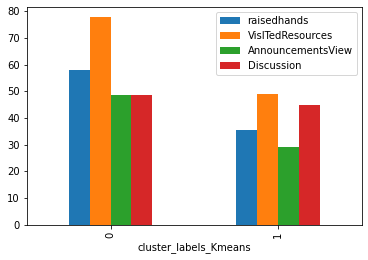

In [214]:
data_cluster_kmeans.groupby('cluster_labels_Kmeans')[numeric_features].mean().plot(legend=True, kind='bar')
plt.show()

Se puede evidenciar que en el primer grupo, la media de todos los atributos númericos es mayor, por lo que se puede concluir que este primer cluster hace referencia a los estudiantes que fueron más activos en clase.

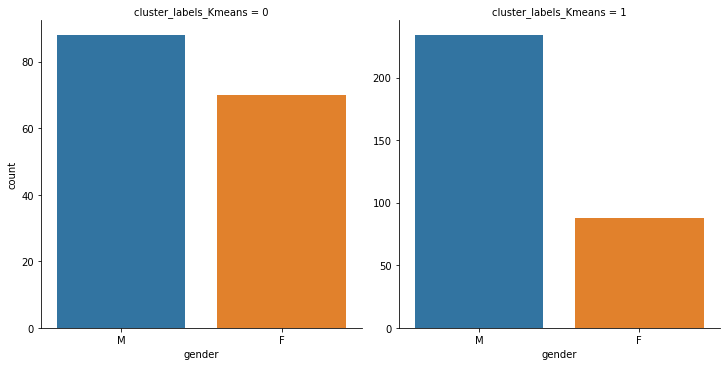

In [215]:
sns.catplot(col="cluster_labels_Kmeans", x = "gender", data = data_cluster_kmeans, kind='count', sharey=False)

No se observan diferencias significativas entre ambos clusters para este atributo


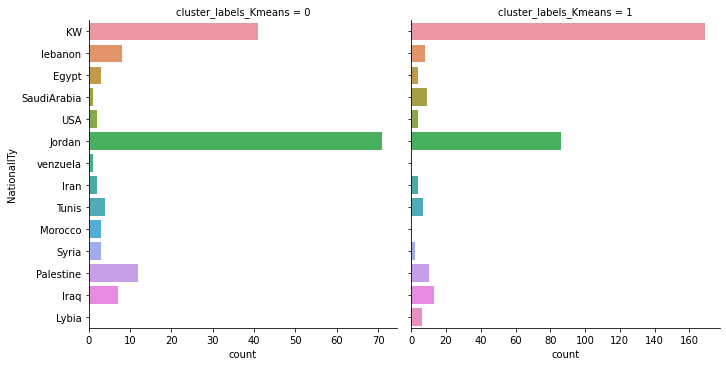

In [216]:
sns.catplot(col="cluster_labels_Kmeans", y = "NationalITy", data = data_cluster_kmeans, kind='count', sharex=False)

No se observan diferencias significativas entre ambos clusters para este atributo

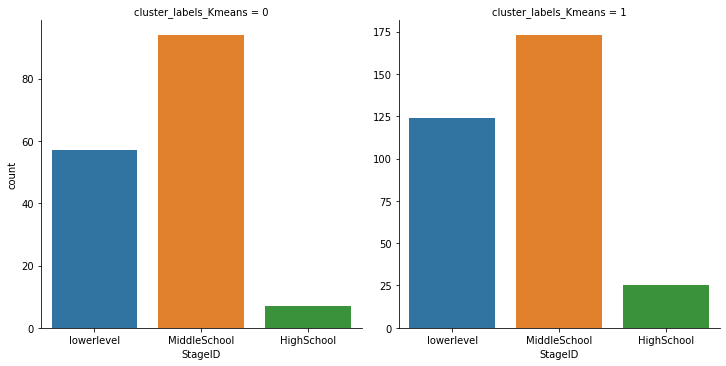

In [217]:
sns.catplot(col="cluster_labels_Kmeans", x = "StageID", data = data_cluster_kmeans, kind='count', sharey=False)

No se observan diferencias significativas entre ambos clusters para este atributo

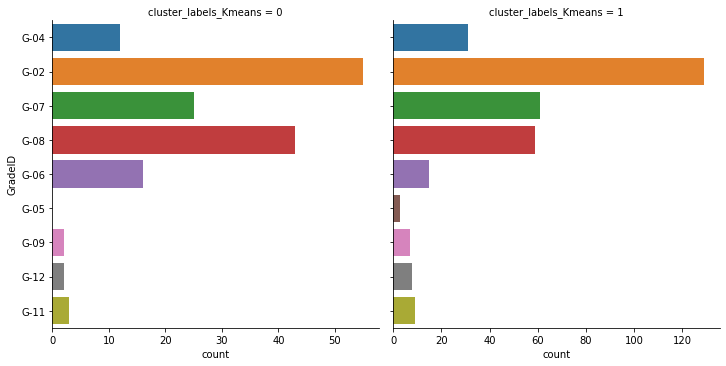

In [218]:
sns.catplot(col="cluster_labels_Kmeans", y = "GradeID", data = data_cluster_kmeans, kind='count', sharex=False)

No se observan diferencias significativas entre ambos clusters para este atributo

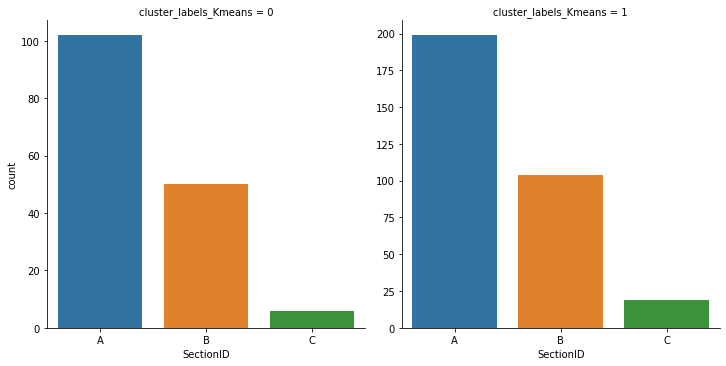

In [219]:
sns.catplot(col="cluster_labels_Kmeans", x = "SectionID", data = data_cluster_kmeans, kind='count', sharey=False)

No se observan diferencias significativas entre ambos clusters para este atributo

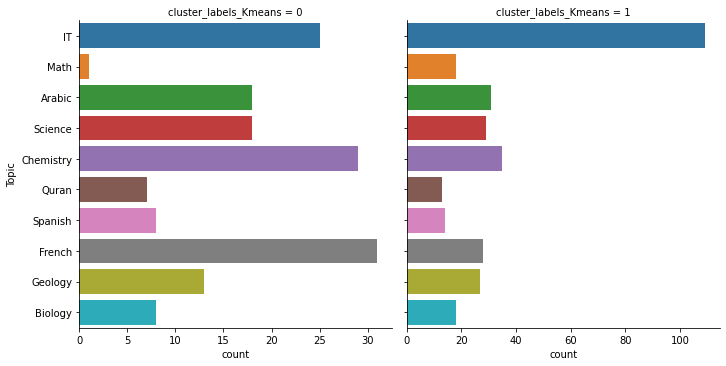

In [220]:
sns.catplot(col="cluster_labels_Kmeans", y = "Topic", data = data_cluster_kmeans, kind='count', sharex=False)

Algunas materias podrían tener un grado de dificultad mayor que otras, como química, francés y matemáticas.

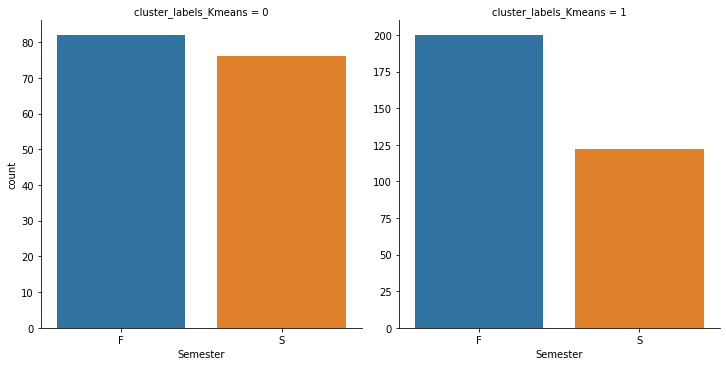

In [221]:
sns.catplot(col="cluster_labels_Kmeans", x = "Semester", data = data_cluster_kmeans, kind='count', sharey=False)

No se observan diferencias significativas entre ambos clusters para este atributo

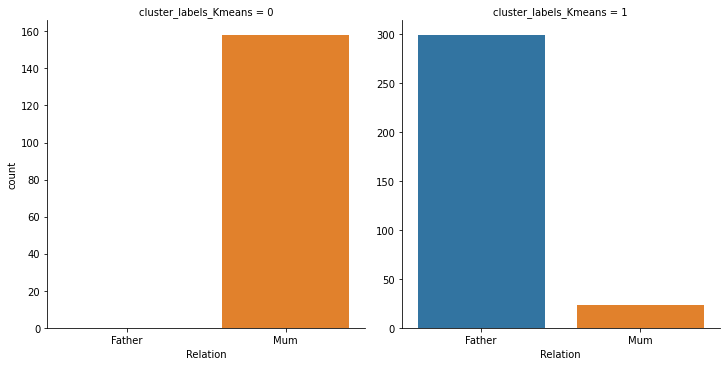

In [222]:
sns.catplot(col="cluster_labels_Kmeans", x = "Relation", data = data_cluster_kmeans, kind='count', sharey=False)

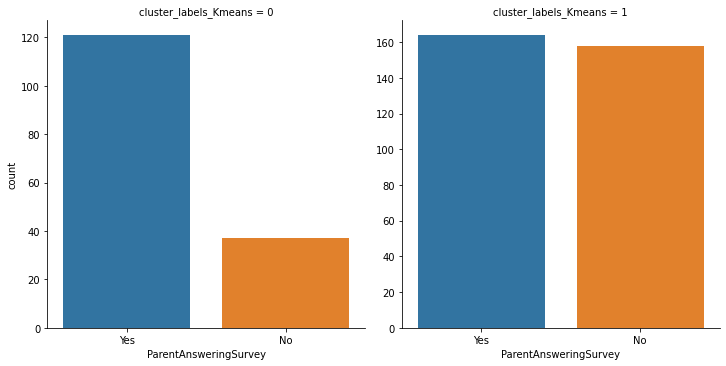

In [223]:
sns.catplot(col="cluster_labels_Kmeans", x = "ParentAnsweringSurvey", data = data_cluster_kmeans, kind='count', sharey=False)

En el primer grupo, la mayoria de padres respondió la encuesta, mientras que en el segundo grupo la mayoría de padres NO la respondió.

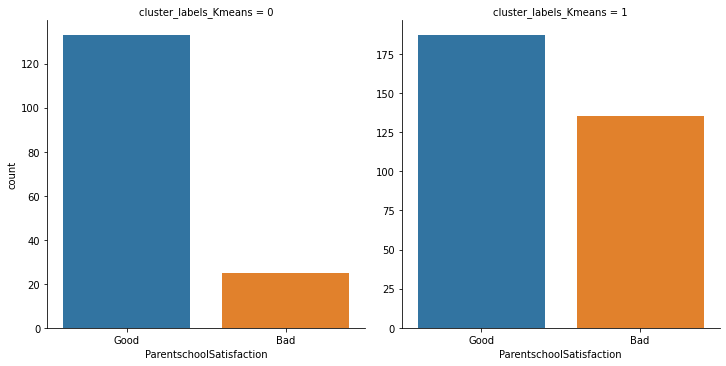

In [224]:
sns.catplot(col="cluster_labels_Kmeans", x = "ParentschoolSatisfaction", data = data_cluster_kmeans, kind='count', sharey=False)

En el primer grupo la satisfaccion de los padres es buena, mientras que en el segundo grupo la satisfacción de los padres es mala.

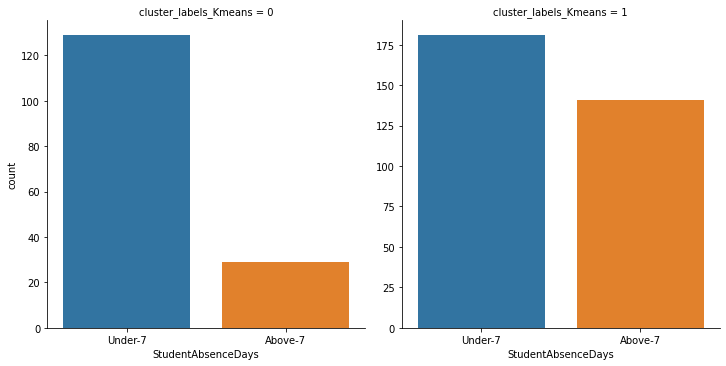

In [225]:
sns.catplot(col="cluster_labels_Kmeans", x = "StudentAbsenceDays", data = data_cluster_kmeans, kind='count', sharey=False)

En el primer grupo la mayoría de estudiantes faltó menos de 7 veces a clase. Mientras en el grupo 2 la mayoría de estudiantes falto más de 7 veces a clase.

En conclusión, el primer grupo hace referencia a estudiantes activos en clase,que tienen una tasa de ausentismo baja y que sus padres tienen una buena relación con la institución. Por otro lado, el segundo grupo de estudiantes en completamente diferente, estudiantes que no participan tanto en clase, que faltan un alto número de veces y además sus padres no tienen una buena relación con la institución.

## Analisis feature importance e hipotesis

Para tener un pequeño acercamiento al feature importance se hará uso de los arboles de decisión ya que en los algoritmos anteriormente utilizados no es posible aplicar este método o pierde interpretabilidad al tratarse de más de dos clases.

In [226]:
# Split dataset into training set and test set (70%-30%)
X_trainRF100, X_testRF100, y_trainRF100, y_testRF100 = train_test_split(X, y, test_size=0.2, random_state=42)
rf100 = RandomForestClassifier(n_estimators=100, random_state=42)
rf100.fit(X_trainRF100, y_trainRF100)
y_predRF100 = rf100.predict(X_testRF100)
print("Accuracy RF 100:",metrics.accuracy_score(y_testRF100, y_predRF100))

Accuracy RF 100: 0.7291666666666666


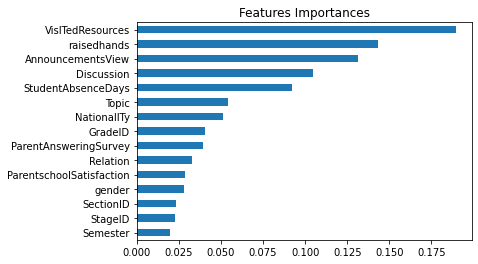

In [227]:
# Create a pd.Series of features importances
importances = pd.Series(data=rf100.feature_importances_,
                        index= X_trainRF100.columns)

# Sort importances
importances_sorted = importances.sort_values()

# Draw a horizontal barplot of importances_sorted
importances_sorted.plot(kind='barh')
plt.title('Features Importances')
plt.show()

Se evidencia que las variables comportamentales tienen una importancia mayor y por tanto presentan un mayor impacto en el resultado de la predicción.

Variables comportamentales vs Desempeño

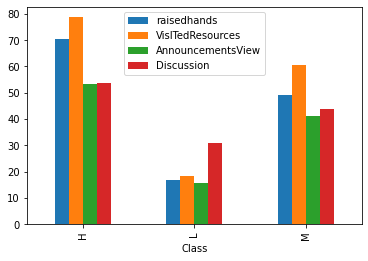

In [228]:
data_original.groupby('Class')[numeric_features].mean().plot(legend=True, kind='bar')
plt.show()

Días de ausencias vs Desempeño

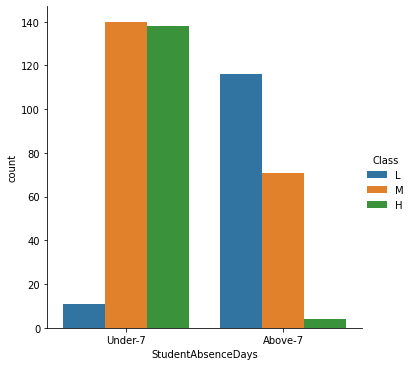

In [229]:
sns.catplot(data = data_original, x = "StudentAbsenceDays", hue="Class", kind = "count", hue_order= ["L", "M", "H"])

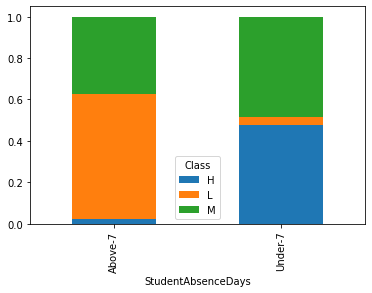

In [230]:
bySAD = data_original.groupby('StudentAbsenceDays').Class.value_counts(normalize = True)
bySAD.unstack().plot(kind='bar', stacked = True)

Topic vs Desempeño

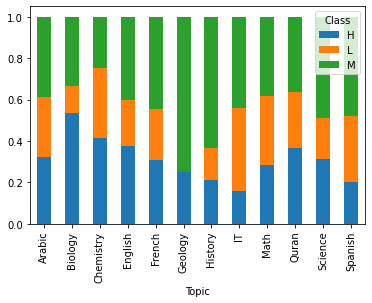

In [231]:
bytopic = data_original.groupby('Topic').Class.value_counts(normalize = True)
bytopic.unstack().plot(kind='bar', stacked = True)

Nacionalidad vs Desempeño

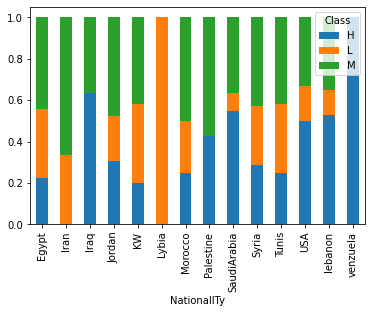

In [232]:
bynationality = data_original.groupby('NationalITy').Class.value_counts(normalize = True)
bynationality.unstack().plot(kind='bar', stacked = True)

Padres que responden la encuesta vs Desempeño

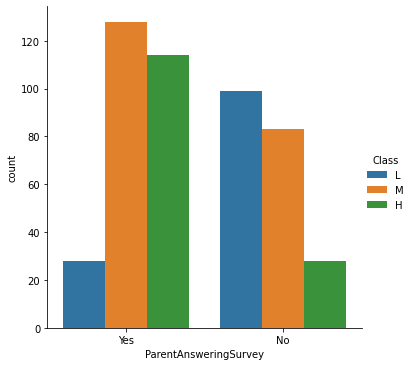

In [233]:
sns.catplot(data = data_original, x = "ParentAnsweringSurvey", hue="Class", kind = "count", hue_order= ["L", "M", "H"])

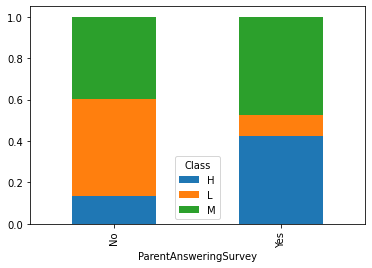

In [234]:
byPAS = data_original.groupby('ParentAnsweringSurvey').Class.value_counts(normalize = True)
byPAS.unstack().plot(kind='bar', stacked = True)

Relación del acudiente vs Desempeño

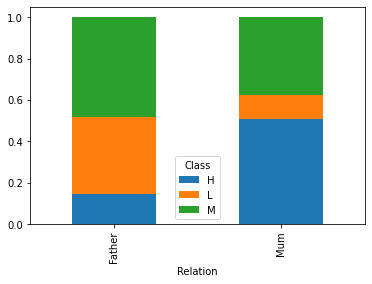

In [235]:
byrelation = data_original.groupby('Relation').Class.value_counts(normalize = True)
byrelation.unstack().plot(kind='bar', stacked = True)

Satisfacción de los padres vs Desempeño

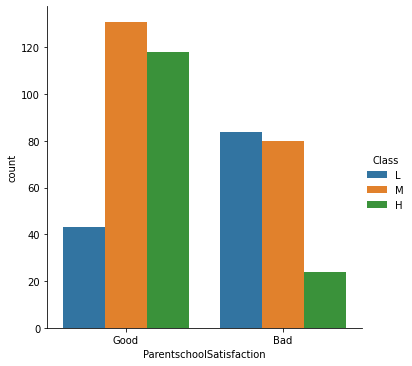

In [236]:
sns.catplot(data = data_original, x = "ParentschoolSatisfaction", hue="Class", kind = "count", hue_order= ["L", "M", "H"])

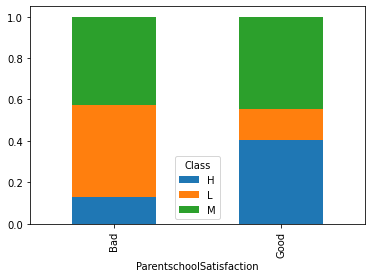

In [237]:
byPAS = data_original.groupby('ParentschoolSatisfaction').Class.value_counts(normalize = True)
byPAS.unstack().plot(kind='bar', stacked = True)

Género vs Desempeño

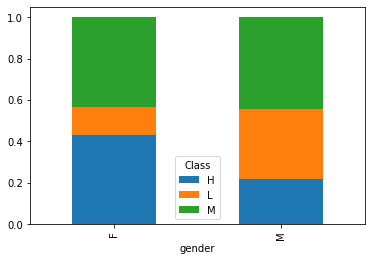

In [238]:
bygender = data_original.groupby('gender').Class.value_counts(normalize = True)
bygender.unstack().plot(kind='bar', stacked = True)

Sección vs Desempeño

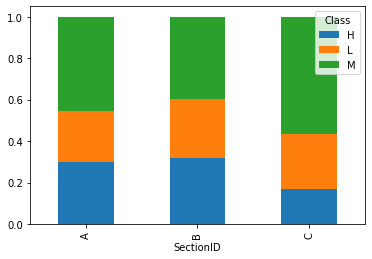

In [239]:
bySID = data_original.groupby('SectionID').Class.value_counts(normalize = True)
bySID.unstack().plot(kind='bar', stacked = True)

Nivel vs Desempeño

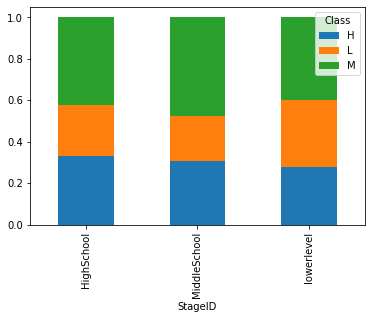

In [240]:
byStID = data_original.groupby('StageID').Class.value_counts(normalize = True)
byStID.unstack().plot(kind='bar', stacked = True)

Semestre vs Desempeño

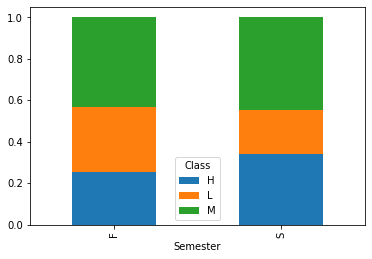

In [241]:
bySemester = data_original.groupby('Semester').Class.value_counts(normalize = True)
bySemester.unstack().plot(kind='bar', stacked = True)

## Conclusión

Los estudiantes que tienen mejor desempeño son aquellos estudiantes que participan activamente en la plataforma y en clase, además de esto, se observa que sus padres tienen una buena relación con la institución.
Adicionalmente, se observa que tener un buen desempeño académico no está relacionado con aspectos como la nacionalidad, el nivel, el género, la sección o el semestre.  


* Proyecto elaborado por Esteban Guerrero Russi y Andrés Leonardo Moreno 